# Comparing RNN vs LSTM vs GRU

In [3]:
# Standard Math / Data libraries
import numpy as np
import pandas as pd

# Data Scrape Package
import pandas_datareader.data as web

# Plotting package
import matplotlib.pyplot as plt
# Scaling Package
from sklearn.preprocessing import MinMaxScaler

# Keras Network @ https://www.tensorflow.org/guide/keras/rnn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Set Random seed
import random
random.seed(2505)

# Larger pictures
plt.rcParams["figure.figsize"] = (20,10)

# Cleaning the Data 

In [4]:
# Daily Data on Bitcoin.
tick = 'BTC-USD'
btc = web.get_data_yahoo(tick,'12/31/2015',interval='d')

In [5]:
btc

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-12-31,432.920990,418.734985,425.875000,430.566986,45996600,430.566986
2016-01-01,436.246002,427.515015,430.721008,434.334015,36278900,434.334015
2016-01-02,436.062012,431.869995,434.622009,433.437988,30096600,433.437988
2016-01-03,433.743011,424.705994,433.578003,430.010986,39633800,430.010986
2016-01-04,434.516998,429.084015,430.061005,433.091003,38477500,433.091003
...,...,...,...,...,...,...
2020-12-30,28937.740234,27360.089844,27360.089844,28840.953125,51287442704,28840.953125
2020-12-31,29244.876953,28201.992188,28841.574219,29001.720703,46754964848,29001.720703
2021-01-01,29600.626953,28803.585938,28994.009766,29374.152344,40730301359,29374.152344


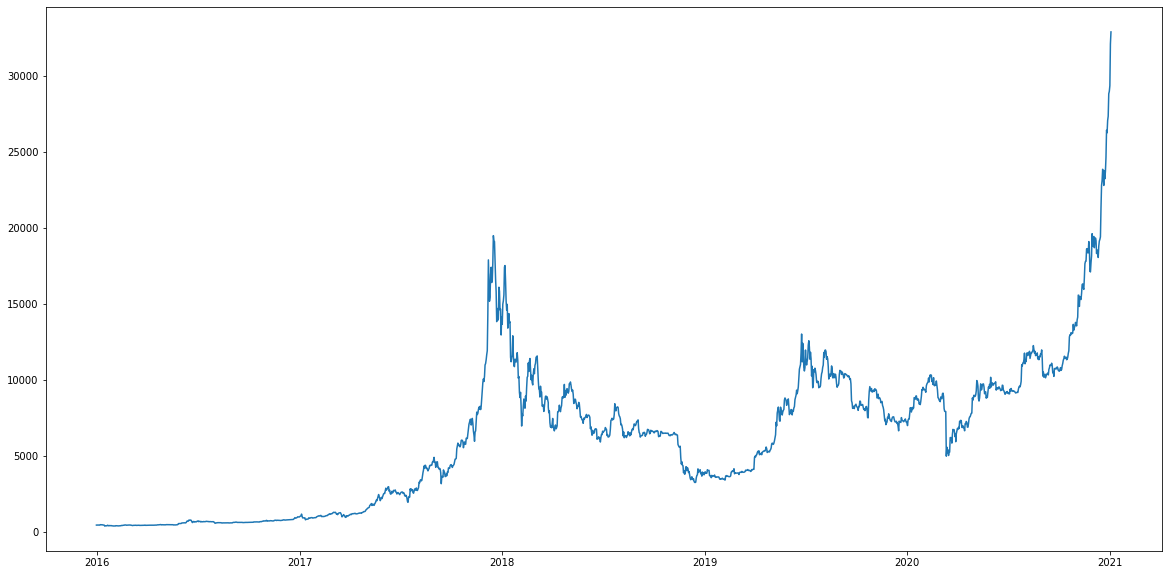

In [6]:
plt.plot(btc['Adj Close'])

In [7]:
print(btc['Adj Close'][0]) # wow. I would've been hella rich if I bought in haha

430.5669860839844


In [8]:
# Used for univariate example.
returns = btc['Adj Close'].pct_change() 

# Use for multivariate example
column_names = btc.columns
x = btc.values #returns a numpy array
# min_max_scaler = MinMaxScaler()
# x_scaled = min_max_scaler.fit_transform(x)
# df = pd.DataFrame(x_scaled)
df = pd.DataFrame(x)
btc_df = df
btc_df.columns = column_names
# Spruce up the last column to predict next 'rate of return'
btc_df['Adj Close'] = btc_df['Adj Close'].pct_change()
btc_df

,High,Low,Open,Close,Volume,Adj Close
0,432.920990,418.734985,425.875000,430.566986,4.599660e+07,NaN
1,436.246002,427.515015,430.721008,434.334015,3.627890e+07,0.008749
2,436.062012,431.869995,434.622009,433.437988,3.009660e+07,-0.002063
3,433.743011,424.705994,433.578003,430.010986,3.963380e+07,-0.007907
4,434.516998,429.084015,430.061005,433.091003,3.847750e+07,0.007163
...,...,...,...,...,...,...
1826,28937.740234,27360.089844,27360.089844,28840.953125,5.128744e+10,0.054034
1827,29244.876953,28201.992188,28841.574219,29001.720703,4.675496e+10,0.005574
1828,29600.626953,28803.585938,28994.009766,29374.152344,4.073030e+10,0.012842
1829,33155.117188,29091.181641,29376.455078,32127.267578,6.786542e+10,0.093726


# Univariate Forecasting LSTM vs GRU vs RNN

In [9]:
returns

Date
2015-12-31         NaN
2016-01-01    0.008749
2016-01-02   -0.002063
2016-01-03   -0.007907
2016-01-04    0.007163
                ...   
2020-12-30    0.054034
2020-12-31    0.005574
2021-01-01    0.012842
2021-01-02    0.093726
2021-01-03    0.024619
Name: Adj Close, Length: 1831, dtype: float64

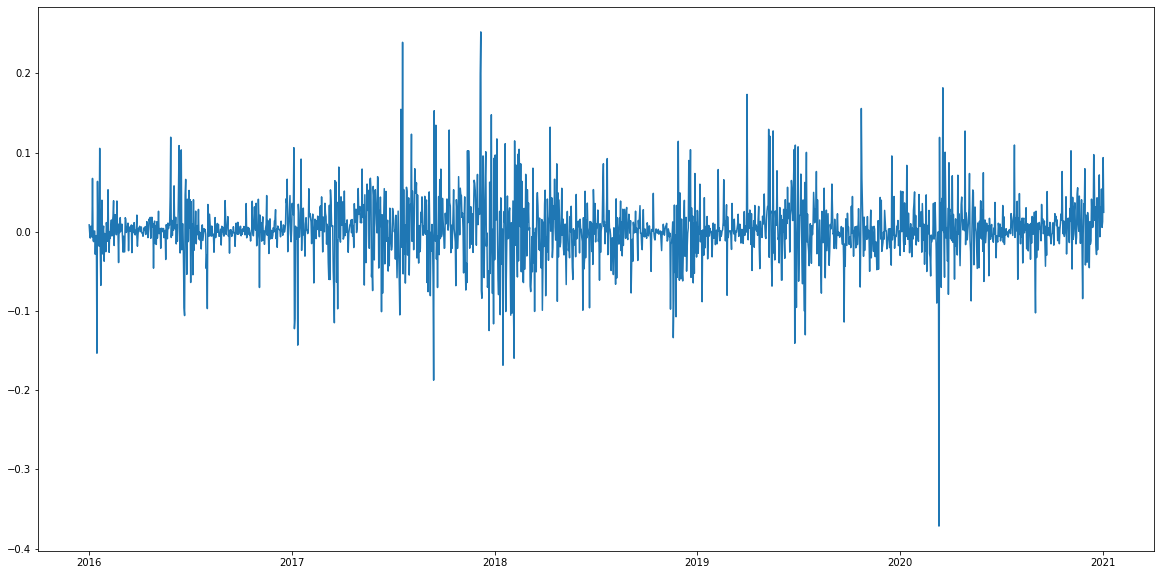

In [10]:
plt.plot(returns)

<AxesSubplot:>

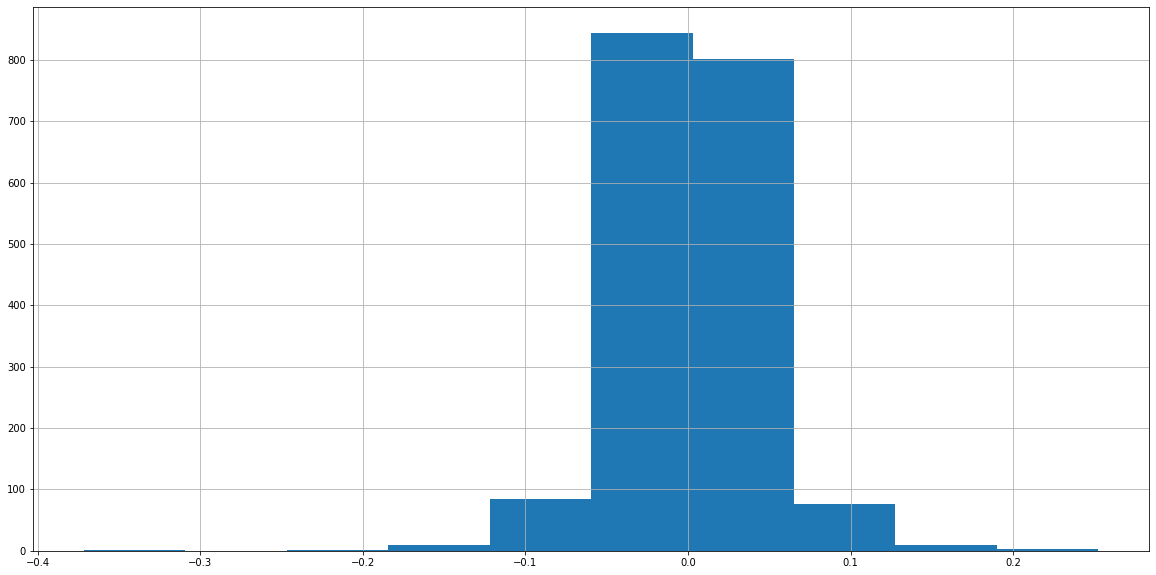

In [11]:
returns.hist()

In [12]:
# Flatten this matrix down.
npa = returns.values[1:].reshape(-1,1) # Python is smart to recognize whatever dimension you need by using this parameter
# Let's scale the data -- this helps avoid the exploding gradient issue
scale = MinMaxScaler(feature_range=(0,1)) # This is by default.
npa = scale.fit_transform(npa)
print(len(npa))

1830


In [13]:
# Need the data to be in the form [sample, time steps, features (dimension of each element)]
samples = 10 # Number of samples (in past)
steps = 1 # Number of steps (in future)
X = [] # X array
Y = [] # Y array
for i in range(npa.shape[0] - samples):
    X.append(npa[i:i+samples]) # Independent Samples
    Y.append(npa[i+samples][0]) # Dependent Samples
print('Training Data: Length is ',len(X[0:1][0]),': ', X[0:1])
print('Testing Data: Length is ', len(Y[0:1]),': ', Y[0:1])

Training Data: Length is  10 :  [array([[0.60952331],
       [0.59220104],
       [0.58283886],
       [0.60698176],
       [0.59132227],
       [0.58491714],
       [0.70356972],
       [0.57865412],
       [0.57564341],
       [0.59686638]])]
Testing Data: Length is  1 :  [0.5970691018558729]


In [14]:
#Reshape the data so that the inputs will be acceptable to the model.
X = np.array(X)
Y = np.array(Y)
print('Dimensions of X', X.shape, 'Dimensions of Y', Y.shape)

threshold = round(0.9 * X.shape[0])
print('Threshold is', threshold)

Dimensions of X (1820, 10, 1) Dimensions of Y (1820,)
Threshold is 1638


In [15]:
def RNN_Example():
    # Let's build the RNN
    model = keras.Sequential()

    # Add a RNN layer with 30 units.
    model.add(layers.SimpleRNN(30,
                               activation = 'tanh',
                               use_bias=True,
                               input_shape=(X.shape[1], X.shape[2])))
    # Add a dropout layer (penalizing more complex models) -- prevents overfitting
    model.add(layers.Dropout(rate=0.2))

    # Add a Dense layer with 1 units (Since we are doing a regression task.
    model.add(layers.Dense(1))

    # Evaluating loss function of MSE using the adam optimizer.
    model.compile(loss='mean_squared_error', optimizer = 'adam')

    # Print out architecture.
    model.summary()
    return model

In [16]:
def GRU_Example():
    # Let's build the GRU
    model = keras.Sequential()

    # Add a GRU layer with 30 units.
    model.add(layers.GRU(30,
                         activation = "tanh",
                         recurrent_activation = "sigmoid",
                         input_shape=(X.shape[1], X.shape[2])))
    # Add a dropout layer (penalizing more complex models) -- prevents overfitting
    model.add(layers.Dropout(rate=0.2))


    # Add a Dense layer with 1 units (Since we are doing a regression task.
    model.add(layers.Dense(1))

    # Evaluating loss function of MSE using the adam optimizer.
    model.compile(loss='mean_squared_error', optimizer = 'adam')

    # Print out architecture.
    model.summary()
    return model

In [17]:
def LSTM_Example():
    # Let's build the LSTM
    model = keras.Sequential()

    # Add a LSTM layer with 10 units.
    model.add(layers.LSTM(30,
                         activation = "tanh",
                         recurrent_activation = "sigmoid",
                         input_shape=(X.shape[1], X.shape[2])))
    # Add a dropout layer (penalizing more complex models) -- prevents overfitting
    model.add(layers.Dropout(rate=0.2))


    # Add a Dense layer with 1 units (Since we are doing a regression task.
    model.add(layers.Dense(1))

    # Evaluating loss function of MSE using the adam optimizer.
    model.compile(loss='mean_squared_error', optimizer = 'adam')

    # Print out architecture.
    model.summary()
    return model

In [18]:
# Intialize models
rnn_model = RNN_Example()
gru_model = GRU_Example()
lstm_model = LSTM_Example()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 30)                960       
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 31        
Total params: 991
Trainable params: 991
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 30)                2970      
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
____________________________________

In [19]:
rnn_trained = rnn_model.fit(X[:threshold],
                            Y[:threshold],
                            shuffle = False, # Since this is time series data
                            epochs=100,
                            batch_size=32,
                            validation_split=0.2,
                            verbose=1) # Verbose outputs data

Epoch 1/100
41/41 [==============================] - 2s 24ms/step - loss: 0.0421 - val_loss: 0.0057
Epoch 2/100
41/41 [==============================] - 0s 3ms/step - loss: 0.0136 - val_loss: 0.0048
Epoch 3/100
41/41 [==============================] - 0s 2ms/step - loss: 0.0098 - val_loss: 0.0046
Epoch 4/100
41/41 [==============================] - 0s 2ms/step - loss: 0.0097 - val_loss: 0.0048
Epoch 5/100
41/41 [==============================] - 0s 2ms/step - loss: 0.0083 - val_loss: 0.0050
Epoch 6/100
41/41 [==============================] - 0s 2ms/step - loss: 0.0080 - val_loss: 0.0045
Epoch 7/100
41/41 [==============================] - 0s 2ms/step - loss: 0.0075 - val_loss: 0.0049
Epoch 8/100
41/41 [==============================] - 0s 2ms/step - loss: 0.0076 - val_loss: 0.0046
Epoch 9/100
41/41 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0043
Epoch 10/100
41/41 [==============================] - 0s 3ms/step - loss: 0.0070 - val_loss: 0.0044
Epoch 11

41/41 [==============================] - 0s 2ms/step - loss: 0.0035 - val_loss: 0.0040
Epoch 84/100
41/41 [==============================] - 0s 2ms/step - loss: 0.0036 - val_loss: 0.0040
Epoch 85/100
41/41 [==============================] - 0s 2ms/step - loss: 0.0036 - val_loss: 0.0040
Epoch 86/100
41/41 [==============================] - 0s 3ms/step - loss: 0.0035 - val_loss: 0.0040
Epoch 87/100
41/41 [==============================] - 0s 3ms/step - loss: 0.0037 - val_loss: 0.0040
Epoch 88/100
41/41 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 0.0040
Epoch 89/100
41/41 [==============================] - 0s 3ms/step - loss: 0.0035 - val_loss: 0.0040
Epoch 90/100
41/41 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 0.0040
Epoch 91/100
41/41 [==============================] - 0s 3ms/step - loss: 0.0036 - val_loss: 0.0040
Epoch 92/100
41/41 [==============================] - 0s 3ms/step - loss: 0.0035 - val_loss: 0.0040
Epoch 93/100


In [20]:
gru_trained = gru_model.fit(X[:threshold],
                            Y[:threshold],
                            shuffle = False, # Since this is time series data
                            epochs=100,
                            batch_size=32,
                            validation_split=0.2,
                            verbose=1) # Verbose outputs data

Epoch 1/100
41/41 [==============================] - 2s 16ms/step - loss: 0.1803 - val_loss: 0.0049
Epoch 2/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0141 - val_loss: 0.0042
Epoch 3/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0110 - val_loss: 0.0042
Epoch 4/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0107 - val_loss: 0.0042
Epoch 5/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0100 - val_loss: 0.0042
Epoch 6/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0085 - val_loss: 0.0042
Epoch 7/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0085 - val_loss: 0.0042
Epoch 8/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0073 - val_loss: 0.0042
Epoch 9/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0067 - val_loss: 0.0042
Epoch 10/100
41/41 [==============================] - 0s 5ms/step - loss: 0.0068 - val_loss: 0.0042
Epoch 11

41/41 [==============================] - 0s 4ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 84/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0040 - val_loss: 0.0040
Epoch 85/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 86/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 87/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 88/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 89/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 90/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 91/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0039 - val_loss: 0.0040
Epoch 92/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 93/100


In [21]:
lstm_trained = lstm_model.fit(X[:threshold],
                              Y[:threshold],
                              shuffle = False, # Since this is time series data
                              epochs=100,
                              batch_size=32,
                              validation_split=0.2,
                              verbose=1) # Verbose outputs data

Epoch 1/100
41/41 [==============================] - 2s 13ms/step - loss: 0.0444 - val_loss: 0.0051
Epoch 2/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0115 - val_loss: 0.0043
Epoch 3/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0095 - val_loss: 0.0044
Epoch 4/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0082 - val_loss: 0.0044
Epoch 5/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0075 - val_loss: 0.0043
Epoch 6/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0067 - val_loss: 0.0043
Epoch 7/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0072 - val_loss: 0.0044
Epoch 8/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0071 - val_loss: 0.0043
Epoch 9/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0064 - val_loss: 0.0043
Epoch 10/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0061 - val_loss: 0.0043
Epoch 11

41/41 [==============================] - 0s 4ms/step - loss: 0.0035 - val_loss: 0.0040
Epoch 84/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0034 - val_loss: 0.0040
Epoch 85/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0035 - val_loss: 0.0040
Epoch 86/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0035 - val_loss: 0.0040
Epoch 87/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0035 - val_loss: 0.0040
Epoch 88/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0035 - val_loss: 0.0040
Epoch 89/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0035 - val_loss: 0.0040
Epoch 90/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0035 - val_loss: 0.0040
Epoch 91/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0034 - val_loss: 0.0040
Epoch 92/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0036 - val_loss: 0.0040
Epoch 93/100


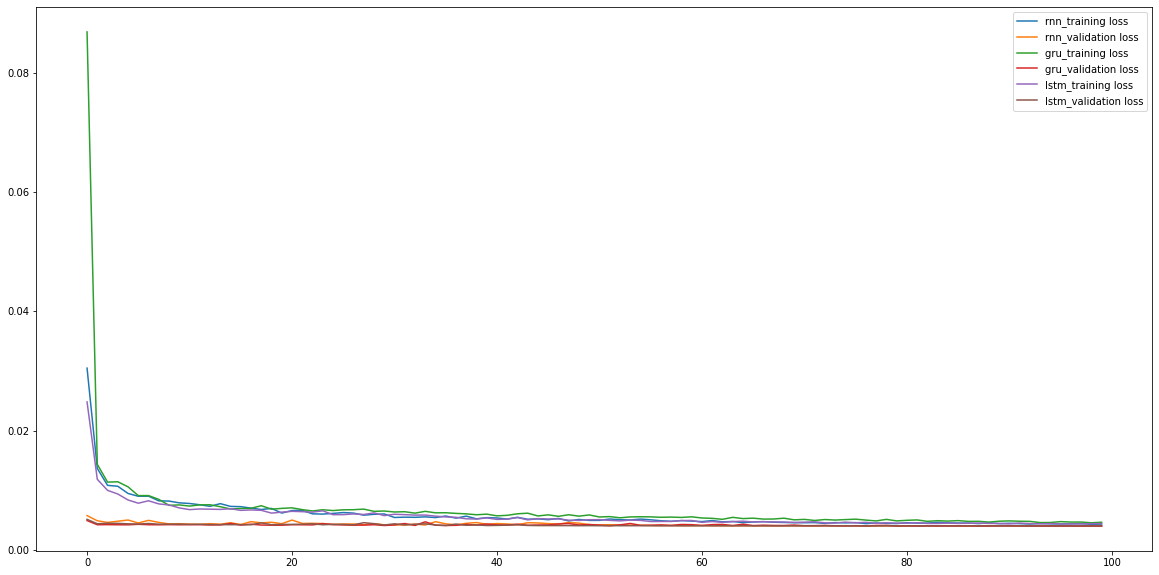

In [22]:
# Plotting the loss iteration
plt.plot(rnn_trained.history['loss'], label = 'rnn_training loss')
plt.plot(rnn_trained.history['val_loss'], label ='rnn_validation loss')
plt.plot(gru_trained.history['loss'], label = 'gru_training loss')
plt.plot(gru_trained.history['val_loss'], label ='gru_validation loss')
plt.plot(lstm_trained.history['loss'], label = 'lstm_training loss')
plt.plot(lstm_trained.history['val_loss'], label ='lstm_validation loss')
plt.legend()
# Note:
# if training loss >> validation loss -> Underfitting
# if training loss << validation loss -> Overfitting (i.e model is smart enough to have mapped the entire dataset..)
# Several ways to address overfitting:
# Reduce complexity of model (hidden layers, neurons, parameters input etc)
# Add dropout and tune rate
# More data :)
# Can predict 'close' somewhere in the next time series.

# Multi-Step Forecast

In [23]:
# Predictions using the 'sliding/rolling window approach'
# Multi step forecast.
# Using self predictions for making future predictions
print(threshold)
true_Y = Y[threshold:] # used for plotting purposes.
pred_Y_rnn = []
pred_Y_gru = []
pred_Y_lstm = []
print('Number of Forecasts to do: ',Y.shape[0] - round(Y.shape[0]*0.9))
latest_input_rnn = X[threshold-1:threshold]
latest_input_gru = X[threshold-1:threshold]
latest_input_lstm = X[threshold-1:threshold]

for i in range(Y.shape[0] - round(Y.shape[0]*0.9) ):
    # Prediction
    p_rnn = rnn_model.predict(latest_input_rnn.reshape(1,X.shape[1],1))[0,0]
    p_gru = gru_model.predict(latest_input_gru.reshape(1,X.shape[1],1))[0,0]
    p_lstm = lstm_model.predict(latest_input_lstm.reshape(1,X.shape[1],1))[0,0]
    
    # Update predictions
    pred_Y_rnn.append(p_rnn)
    pred_Y_gru.append(p_gru)
    pred_Y_lstm.append(p_lstm)
    
    # Update X input
    latest_input_rnn = np.append(X[threshold][1:], p_rnn)
    latest_input_gru = np.append(X[threshold][1:], p_gru)
    latest_input_lstm = np.append(X[threshold][1:], p_lstm)

1638
Number of Forecasts to do:  182


RNN [0.58955467, 0.5906277, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.5906233, 0.59

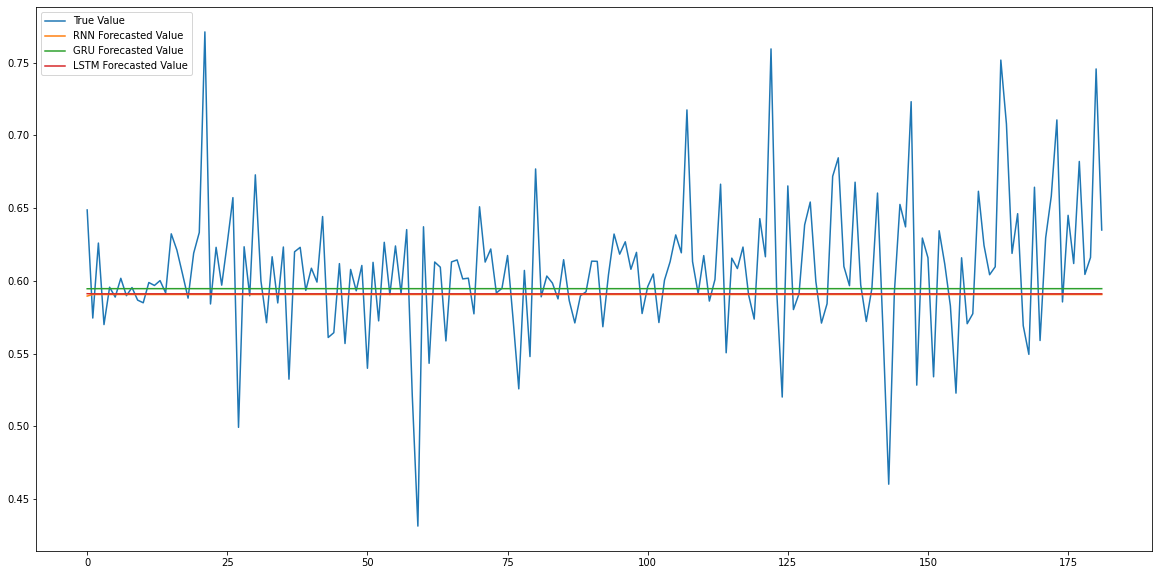

In [24]:
plt.plot(true_Y, label = 'True Value')
plt.plot(pred_Y_rnn, label = 'RNN Forecasted Value')
plt.plot(pred_Y_gru, label = 'GRU Forecasted Value')
plt.plot(pred_Y_lstm, label = 'LSTM Forecasted Value')
plt.legend()
# Model just copied the same value over and over again. Hence, model is not very robust.
# Makes a ton of sense of time series since the most recent data is dependent on the previous observation
# Model is not that great... not really doing much.
# It's just predicting the mean.
print('RNN', pred_Y_rnn)
print('GRU', pred_Y_gru)
print('LSTM', pred_Y_lstm)

# Multi-Variate Forecasting

In [25]:
# Using btc_df (from the prior cleaning)
btc_df

,High,Low,Open,Close,Volume,Adj Close
0,432.920990,418.734985,425.875000,430.566986,4.599660e+07,NaN
1,436.246002,427.515015,430.721008,434.334015,3.627890e+07,0.008749
2,436.062012,431.869995,434.622009,433.437988,3.009660e+07,-0.002063
3,433.743011,424.705994,433.578003,430.010986,3.963380e+07,-0.007907
4,434.516998,429.084015,430.061005,433.091003,3.847750e+07,0.007163
...,...,...,...,...,...,...
1826,28937.740234,27360.089844,27360.089844,28840.953125,5.128744e+10,0.054034
1827,29244.876953,28201.992188,28841.574219,29001.720703,4.675496e+10,0.005574
1828,29600.626953,28803.585938,28994.009766,29374.152344,4.073030e+10,0.012842
1829,33155.117188,29091.181641,29376.455078,32127.267578,6.786542e+10,0.093726


In [26]:
# Need the data to be in the form [sample, time steps, features (dimension of each element)]
samples = 10 # Number of samples (in past)
steps = 1 # Number of steps (in future)
X = [] # X array
Y = [] # Y array
for i in range(btc_df.shape[0] - samples):
    X.append(btc_df.iloc[i:i+samples, 0:5].values) # Independent Samples
    Y.append(btc_df.iloc[i+samples, 5:].values) # Dependent Samples
print('Training Data: Length is ',len(X[0:1][0]),': ', X[0:1])
print('Testing Data: Length is ', len(Y[0:1]),': ', Y[0:1])

Training Data: Length is  10 :  [array([[4.32920990e+02, 4.18734985e+02, 4.25875000e+02, 4.30566986e+02,
        4.59966000e+07],
       [4.36246002e+02, 4.27515015e+02, 4.30721008e+02, 4.34334015e+02,
        3.62789000e+07],
       [4.36062012e+02, 4.31869995e+02, 4.34622009e+02, 4.33437988e+02,
        3.00966000e+07],
       [4.33743011e+02, 4.24705994e+02, 4.33578003e+02, 4.30010986e+02,
        3.96338000e+07],
       [4.34516998e+02, 4.29084015e+02, 4.30061005e+02, 4.33091003e+02,
        3.84775000e+07],
       [4.34182007e+02, 4.29675995e+02, 4.33069000e+02, 4.31959991e+02,
        3.45226000e+07],
       [4.31855988e+02, 4.26341003e+02, 4.31855988e+02, 4.29105011e+02,
        3.40425000e+07],
       [4.58765991e+02, 4.29076996e+02, 4.30010986e+02, 4.58048004e+02,
        8.75622000e+07],
       [4.62933990e+02, 4.47937988e+02, 4.57537994e+02, 4.53230011e+02,
        5.69930000e+07],
       [4.54640015e+02, 4.46889008e+02, 4.53382996e+02, 4.47610992e+02,
        3.22780000e+07

In [27]:
#Reshape the data so that the inputs will be acceptable to the model.
X = np.array(X)
Y = np.array(Y)
print('Dimensions of X', X.shape, 'Dimensions of Y', Y.shape)

Dimensions of X (1821, 10, 5) Dimensions of Y (1821, 1)


In [28]:
# # Get the training and testing set
threshold = round(0.9 * X.shape[0])
trainX, trainY = X[:threshold], Y[:threshold]
testX, testY =  X[threshold:], Y[threshold:]
print('Training Length',trainX.shape, trainY.shape,'Testing Length:',testX.shape, testY.shape)

Training Length (1639, 10, 5) (1639, 1) Testing Length: (182, 10, 5) (182, 1)


In [29]:
# Reinitialize the models
rnn_model = RNN_Example()
gru_model = GRU_Example()
lstm_model = LSTM_Example()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 30)                1080      
_________________________________________________________________
dropout_3 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 31        
Total params: 1,111
Trainable params: 1,111
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 30)                3330      
_________________________________________________________________
dropout_4 (Dropout)          (None, 30)                0         
______________________________

In [30]:
# Retraining the models
rnn_trained = rnn_model.fit(trainX,
                            trainY,
                            shuffle = False, # Since this is time series data
                            epochs=100,
                            batch_size=32,
                            validation_split=0.2,
                            verbose=1) # Verbose outputs data

Epoch 1/100
41/41 [==============================] - 1s 7ms/step - loss: 3.6636 - val_loss: 0.8188
Epoch 2/100
41/41 [==============================] - 0s 3ms/step - loss: 1.0187 - val_loss: 0.0600
Epoch 3/100
41/41 [==============================] - 0s 3ms/step - loss: 0.6236 - val_loss: 0.0022
Epoch 4/100
41/41 [==============================] - 0s 2ms/step - loss: 0.4782 - val_loss: 0.0016
Epoch 5/100
41/41 [==============================] - 0s 2ms/step - loss: 0.5359 - val_loss: 0.0016
Epoch 6/100
41/41 [==============================] - 0s 2ms/step - loss: 0.4846 - val_loss: 0.0017
Epoch 7/100
41/41 [==============================] - 0s 2ms/step - loss: 0.4641 - val_loss: 0.0016
Epoch 8/100
41/41 [==============================] - 0s 2ms/step - loss: 0.4489 - val_loss: 0.0020
Epoch 9/100
41/41 [==============================] - 0s 2ms/step - loss: 0.4657 - val_loss: 0.0017
Epoch 10/100
41/41 [==============================] - 0s 2ms/step - loss: 0.4353 - val_loss: 0.0018
Epoch 11/

41/41 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 84/100
41/41 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 85/100
41/41 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 86/100
41/41 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 87/100
41/41 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 88/100
41/41 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 89/100
41/41 [==============================] - 0s 2ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 90/100
41/41 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 91/100
41/41 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 92/100
41/41 [==============================] - 0s 2ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 93/100


In [31]:
gru_trained = gru_model.fit(trainX,
                            trainY,
                            shuffle = False, # Since this is time series data
                            epochs=100,
                            batch_size=32,
                            validation_split=0.2,
                            verbose=1) # Verbose outputs data

Epoch 1/100
41/41 [==============================] - 2s 13ms/step - loss: 0.1331 - val_loss: 0.0016
Epoch 2/100
41/41 [==============================] - 0s 5ms/step - loss: 0.1037 - val_loss: 0.0016
Epoch 3/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0872 - val_loss: 0.0016
Epoch 4/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0722 - val_loss: 0.0016
Epoch 5/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0478 - val_loss: 0.0015
Epoch 6/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0446 - val_loss: 0.0016
Epoch 7/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0336 - val_loss: 0.0019
Epoch 8/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0232 - val_loss: 0.0016
Epoch 9/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0201 - val_loss: 0.0016
Epoch 10/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0146 - val_loss: 0.0015
Epoch 11

41/41 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 84/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 85/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 86/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 87/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 88/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 89/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 90/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 91/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 92/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 93/100


In [32]:
lstm_trained = lstm_model.fit(trainX,
                              trainY,
                              shuffle = False, # Since this is time series data
                              epochs=100,
                              batch_size=32,
                              validation_split=0.2,
                              verbose=1) # Verbose outputs data

Epoch 1/100
41/41 [==============================] - 2s 13ms/step - loss: 0.1143 - val_loss: 0.0150
Epoch 2/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0409 - val_loss: 0.0019
Epoch 3/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0334 - val_loss: 0.0015
Epoch 4/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0272 - val_loss: 0.0015
Epoch 5/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0243 - val_loss: 0.0015
Epoch 6/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0211 - val_loss: 0.0016
Epoch 7/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0188 - val_loss: 0.0015
Epoch 8/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0139 - val_loss: 0.0015
Epoch 9/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0133 - val_loss: 0.0016
Epoch 10/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0113 - val_loss: 0.0016
Epoch 11

41/41 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 84/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 85/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 86/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 87/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 88/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 89/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 90/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 91/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 92/100
41/41 [==============================] - 0s 4ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 93/100


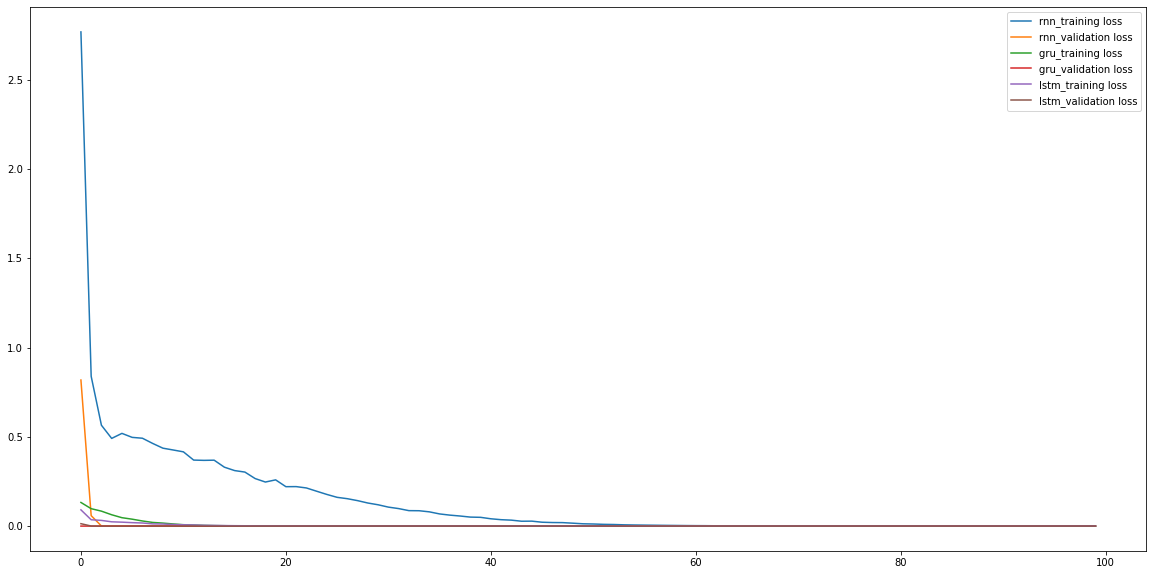

In [33]:
# Plotting the loss iteration
plt.plot(rnn_trained.history['loss'], label = 'rnn_training loss')
plt.plot(rnn_trained.history['val_loss'], label ='rnn_validation loss')
plt.plot(gru_trained.history['loss'], label = 'gru_training loss')
plt.plot(gru_trained.history['val_loss'], label ='gru_validation loss')
plt.plot(lstm_trained.history['loss'], label = 'lstm_training loss')
plt.plot(lstm_trained.history['val_loss'], label ='lstm_validation loss')
plt.legend()
# Note:
# if training loss >> validation loss -> Underfitting
# if training loss << validation loss -> Overfitting (i.e model is smart enough to have mapped the entire dataset..)
# Several ways to address overfitting:
# Reduce complexity of model (hidden layers, neurons, parameters input etc)
# Add dropout and tune rate
# More data :)
# Can predict 'close' somewhere in the next time series.

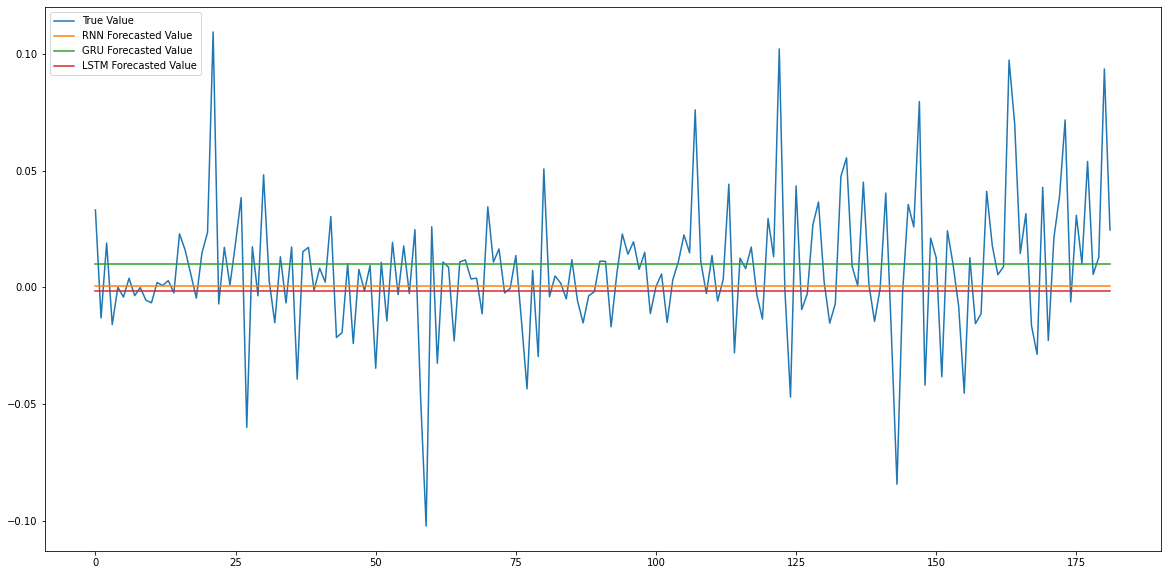

In [34]:
# This is a one step forecast (based on how we constructed our model)
y_pred_rnn = rnn_model.predict(testX)
y_pred_gru = gru_model.predict(testX)
y_pred_lstm = lstm_model.predict(testX)
plt.plot(testY, label = 'True Value')
plt.plot(y_pred_rnn, label = 'RNN Forecasted Value')
plt.plot(y_pred_gru, label = 'GRU Forecasted Value')
plt.plot(y_pred_lstm, label = 'LSTM Forecasted Value')
plt.legend()

In [35]:
# Don't be deceived by this plot that I will create here!
btc = web.get_data_yahoo(tick,'12/31/2015',interval='d')
column_names = btc.columns
x = btc.values #returns a numpy array
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)
btc_scaled = df
btc_scaled.columns = column_names
btc_scaled

,High,Low,Open,Close,Volume,Adj Close
0,0.001696,0.002013,0.001878,0.002034,0.000211,0.002034
1,0.001794,0.002290,0.002028,0.002150,0.000094,0.002150
2,0.001788,0.002428,0.002148,0.002122,0.000019,0.002122
3,0.001720,0.002202,0.002116,0.002017,0.000134,0.002017
4,0.001743,0.002340,0.002007,0.002112,0.000120,0.002112
...,...,...,...,...,...,...
1826,0.835761,0.851871,0.833786,0.874551,0.617890,0.874551
1827,0.844748,0.878429,0.879544,0.879489,0.563254,0.879489
1828,0.855158,0.897406,0.884253,0.890926,0.490631,0.890926
1829,0.959164,0.906478,0.896065,0.975478,0.817726,0.975478


In [36]:
# Need the data to be in the form [sample, time steps, features (dimension of each element)]
samples = 10 # Number of samples (in past)
steps = 1 # Number of steps (in future)
X = [] # X array
Y = [] # Y array
for i in range(btc_scaled.shape[0] - samples):
    X.append(btc_scaled.iloc[i:i+samples, 0:5].values) # Independent Samples
    Y.append(btc_scaled.iloc[i+samples, 5:].values) # Dependent Samples
print('Training Data: Length is ',len(X[0:1][0]),': ', X[0:1])
print('Testing Data: Length is ', len(Y[0:1]),': ', Y[0:1])

Training Data: Length is  10 :  [array([[1.69625966e-03, 2.01321649e-03, 1.87797168e-03, 2.03418679e-03,
        2.10740348e-04],
       [1.79355117e-03, 2.29018025e-03, 2.02764876e-03, 2.14987676e-03,
        9.36003641e-05],
       [1.78816752e-03, 2.42755699e-03, 2.14813771e-03, 2.12235871e-03,
        1.90771209e-05],
       [1.72031242e-03, 2.20157041e-03, 2.11589183e-03, 2.01711137e-03,
        1.34041305e-04],
       [1.74295965e-03, 2.33967396e-03, 2.00726344e-03, 2.11170239e-03,
        1.20102928e-04],
       [1.73315764e-03, 2.35834781e-03, 2.10017043e-03, 2.07696765e-03,
        7.24294128e-05],
       [1.66509716e-03, 2.25314637e-03, 2.06270450e-03, 1.98928778e-03,
        6.66421477e-05],
       [2.45249725e-03, 2.33945254e-03, 2.00571854e-03, 2.87816182e-03,
        7.11784185e-04],
       [2.57445499e-03, 2.93441769e-03, 2.85593630e-03, 2.73019547e-03,
        3.43294153e-04],
       [2.33176913e-03, 2.90132786e-03, 2.72760220e-03, 2.55762867e-03,
        4.53723513e-05

In [37]:
#Reshape the data so that the inputs will be acceptable to the model.
X = np.array(X)
Y = np.array(Y)
print('Dimensions of X', X.shape, 'Dimensions of Y', Y.shape)

Dimensions of X (1821, 10, 5) Dimensions of Y (1821, 1)


In [38]:
# # Get the training and testing set
threshold = round(0.9 * X.shape[0])
trainX, trainY = X[:threshold], Y[:threshold]
testX, testY =  X[threshold:], Y[threshold:]
print('Training Length',trainX.shape, trainY.shape,'Testing Length:',testX.shape, testY.shape)

Training Length (1639, 10, 5) (1639, 1) Testing Length: (182, 10, 5) (182, 1)


In [39]:
# Reinitialize the models
rnn_model = RNN_Example()
gru_model = GRU_Example()
lstm_model = LSTM_Example()
# Retraining the models
rnn_trained = rnn_model.fit(trainX,
                            trainY,
                            shuffle = False, # Since this is time series data
                            epochs=100,
                            batch_size=32,
                            validation_split=0.2,
                            verbose=1) # Verbose outputs data
gru_trained = gru_model.fit(trainX,
                            trainY,
                            shuffle = False, # Since this is time series data
                            epochs=100,
                            batch_size=32,
                            validation_split=0.2,
                            verbose=1) # Verbose outputs data
lstm_trained = lstm_model.fit(trainX,
                              trainY,
                              shuffle = False, # Since this is time series data
                              epochs=100,
                              batch_size=32,
                              validation_split=0.2,
                              verbose=1) # Verbose outputs data

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 30)                1080      
_________________________________________________________________
dropout_6 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 31        
Total params: 1,111
Trainable params: 1,111
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 30)                3330      
_________________________________________________________________
dropout_7 (Dropout)          (None, 30)                0         
______________________________

41/41 [==============================] - 0s 4ms/step - loss: 2.9726e-04 - val_loss: 4.4235e-04
Epoch 34/100
41/41 [==============================] - 0s 4ms/step - loss: 2.3322e-04 - val_loss: 4.6778e-04
Epoch 35/100
41/41 [==============================] - 0s 4ms/step - loss: 2.2587e-04 - val_loss: 4.2386e-04
Epoch 36/100
41/41 [==============================] - 0s 5ms/step - loss: 3.0347e-04 - val_loss: 4.1448e-04
Epoch 37/100
41/41 [==============================] - 0s 4ms/step - loss: 2.1388e-04 - val_loss: 4.1997e-04
Epoch 38/100
41/41 [==============================] - 0s 4ms/step - loss: 2.7055e-04 - val_loss: 3.8474e-04
Epoch 39/100
41/41 [==============================] - 0s 4ms/step - loss: 1.7945e-04 - val_loss: 4.1604e-04
Epoch 40/100
41/41 [==============================] - 0s 4ms/step - loss: 2.5373e-04 - val_loss: 4.2420e-04
Epoch 41/100
41/41 [==============================] - 0s 4ms/step - loss: 1.8655e-04 - val_loss: 4.2874e-04
Epoch 42/100
41/41 [=====================

Epoch 85/100
41/41 [==============================] - 0s 4ms/step - loss: 2.2928e-04 - val_loss: 1.6036e-04
Epoch 86/100
41/41 [==============================] - 0s 4ms/step - loss: 2.0310e-04 - val_loss: 1.7703e-04
Epoch 87/100
41/41 [==============================] - 0s 4ms/step - loss: 1.8356e-04 - val_loss: 1.6450e-04
Epoch 88/100
41/41 [==============================] - 0s 4ms/step - loss: 2.0439e-04 - val_loss: 1.6558e-04
Epoch 89/100
41/41 [==============================] - 0s 4ms/step - loss: 1.6990e-04 - val_loss: 1.6105e-04
Epoch 90/100
41/41 [==============================] - 0s 4ms/step - loss: 1.8145e-04 - val_loss: 1.7289e-04
Epoch 91/100
41/41 [==============================] - 0s 4ms/step - loss: 1.8338e-04 - val_loss: 1.8676e-04
Epoch 92/100
41/41 [==============================] - 0s 4ms/step - loss: 1.8182e-04 - val_loss: 1.8308e-04
Epoch 93/100
41/41 [==============================] - 0s 4ms/step - loss: 2.0112e-04 - val_loss: 2.0424e-04
Epoch 94/100
41/41 [========

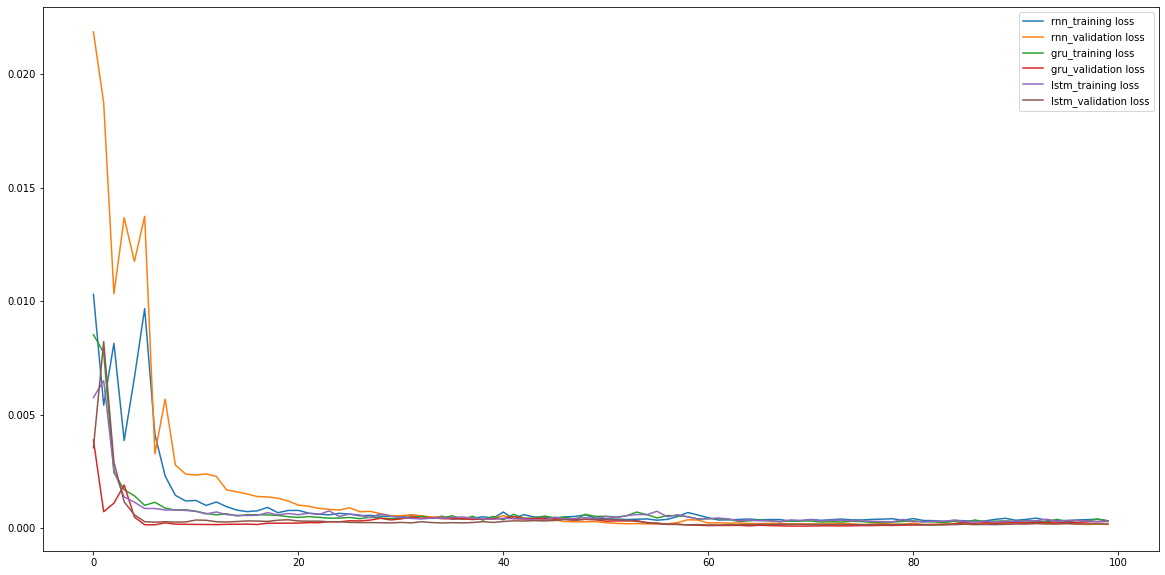

In [40]:
# Plotting the loss iteration
plt.plot(rnn_trained.history['loss'], label = 'rnn_training loss')
plt.plot(rnn_trained.history['val_loss'], label ='rnn_validation loss')
plt.plot(gru_trained.history['loss'], label = 'gru_training loss')
plt.plot(gru_trained.history['val_loss'], label ='gru_validation loss')
plt.plot(lstm_trained.history['loss'], label = 'lstm_training loss')
plt.plot(lstm_trained.history['val_loss'], label ='lstm_validation loss')
plt.legend()
# Note:
# if training loss >> validation loss -> Underfitting
# if training loss << validation loss -> Overfitting (i.e model is smart enough to have mapped the entire dataset..)
# Several ways to address overfitting:
# Reduce complexity of model (hidden layers, neurons, parameters input etc)
# Add dropout and tune rate
# More data :)
# Can predict 'close' somewhere in the next time series.

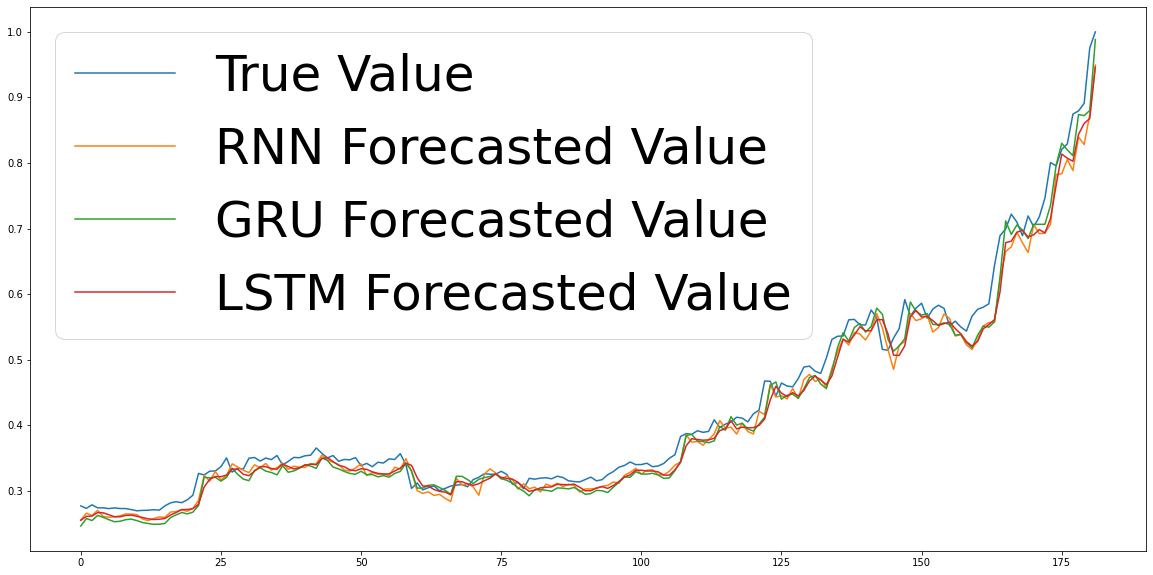

In [47]:
# This is a one step forecast (based on how we constructed our model)
y_pred_rnn = rnn_model.predict(testX)
y_pred_gru = gru_model.predict(testX)
y_pred_lstm = lstm_model.predict(testX)
plt.plot(testY, label = 'True Value')
plt.plot(y_pred_rnn, label = 'RNN Forecasted Value')
plt.plot(y_pred_gru, label = 'GRU Forecasted Value')
plt.plot(y_pred_lstm, label = 'LSTM Forecasted Value')
plt.legend(fontsize=50)
# plt.legend()

In [59]:
rnn_model.get_weights()

[array([[ 0.05413565,  0.05179131,  0.05089777,  0.28138912,  0.3355662 ,
         -0.2628196 ,  0.13391022,  0.03019162,  0.2311035 ,  0.01066415,
          0.38281286,  0.2667898 ,  0.29233176, -0.08754133, -0.34676003,
          0.14523223,  0.32101724, -0.20938562,  0.30176792, -0.06615949,
          0.338696  , -0.18901007,  0.12468252, -0.33424175, -0.15765308,
          0.00330863, -0.10060425,  0.37529412, -0.36689383,  0.20293368],
        [ 0.06678943,  0.07542956,  0.11145053,  0.30666548, -0.18048017,
          0.3897153 , -0.12880766,  0.14835694, -0.03944907, -0.40162116,
         -0.31822634, -0.10645454, -0.11700929, -0.33694047, -0.3375114 ,
          0.3542082 , -0.18072452, -0.38826272, -0.07378162, -0.32454777,
          0.03285588,  0.1277599 , -0.31926712, -0.31940895, -0.26795208,
          0.1881217 ,  0.06737895, -0.10917184, -0.3243166 , -0.07895191],
        [ 0.10673006, -0.07323437,  0.24071059, -0.2893505 , -0.03343771,
         -0.22917742, -0.31098682,  

In [57]:
gru_model.get_weights()

[array([[-0.48459974,  0.29924804,  0.08974588, -0.74373955, -0.10607919,
         -0.27812737,  0.16927063, -0.11466715, -0.5666831 ,  0.12134933,
         -0.2526899 ,  0.05104671,  0.38734347,  0.42424345, -0.39569673,
         -0.07126996, -0.12493648, -0.35897717,  0.4539288 , -0.4491734 ,
         -0.6441773 , -0.39731553, -0.17965993, -0.24586415, -0.18637222,
          0.43870118, -0.01425467,  0.11155785, -0.6377806 , -0.09080627,
         -0.12614147, -0.04090158, -0.1880632 , -0.12983607,  0.15027201,
          0.02746446,  0.10378395, -0.19736604, -0.11985037, -0.15869376,
         -0.1411363 ,  0.202225  ,  0.03103113,  0.07725082, -0.043552  ,
         -0.00803309,  0.15046442,  0.21183777,  0.23032372,  0.13634756,
         -0.10054293, -0.15207395,  0.06924793, -0.06804597, -0.07634   ,
          0.10515462, -0.09552728,  0.09680188,  0.0568668 , -0.34559095,
         -0.03085763, -0.03199366,  0.00700175,  0.02686577, -0.19565047,
          0.24345961, -0.07903139,  0.

In [58]:
lstm_model.get_weights()

[array([[-1.60129026e-01, -8.61848220e-02, -8.30406472e-02,
         -8.29092506e-03,  8.74241143e-02,  6.09269142e-02,
          2.85230398e-01, -1.53667033e-01,  9.58941504e-02,
          9.85503569e-02,  1.44088659e-02,  1.26284482e-02,
         -1.31958723e-01,  1.74904302e-01,  3.15976322e-01,
          1.58135459e-01,  1.97603598e-01, -6.47577271e-02,
         -1.52049810e-01, -2.44197547e-02, -7.54070356e-02,
          5.61500713e-02,  1.07734278e-01, -3.45431245e-03,
          1.94275722e-01, -1.37882650e-01,  2.58845329e-01,
          1.78417802e-01,  8.31803530e-02,  3.54054570e-02,
          1.97819337e-01,  1.93228185e-01,  2.08020046e-01,
          1.89105775e-02, -1.49948418e-01,  5.85325807e-02,
         -2.25423574e-02, -4.17238399e-02, -7.24729011e-03,
         -1.17134586e-01, -1.38504013e-01,  1.46512166e-01,
         -1.79873213e-01,  1.97901338e-01, -2.29651138e-01,
         -1.42933860e-01,  1.04311258e-01,  1.83249682e-01,
         -8.96427035e-02,  1.55005708e-0

In [60]:
# Let's save the model weights and use this again in a different notebook...
# RNN
rnn_model.save('rnn_btc.h5')
# GRU
gru_model.save('gru_btc.h5')
# LSTM
lstm_model.save('lstm_btc.h5')